In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from utils.sersic_functions import sersic_profile, generate_random_pos
from utils.download_data.h2f_download_functions import get_galaxy_img

# all pasquet dataset
# 0.05% -> 982883
# 0.02% -> 610370
# 0.01% -> 527723
# 0.001% -> 501835

# only train split (301096)
# 0.02% -> 366458
# 0.05% -> 590461

# X_train_autolabeling_pasquet (correcto) 193 any, 0 all
# X_val_autolabeling_pasquet (correcto) 40 any, 0 all
# X_test_autolabeling_pasquet (correcto) 52 any, 0 all

# X_train_pasquet (mal) 201 any, 29 all
# X_val_pasquet (mal) 48 any, 11 all

In [ ]:
df = pd.read_csv("../data/SERSIC/df_pasquet_val.csv")

In [10]:
imgs = np.load("/home/acontreras/PRISM/data/SERSIC/X_train_autolabeling_delight_002_percent_3.npz")["imgs"]
mask = (imgs.sum((3,4))==0).all((1,2))


#imgs[mask] = imgs_faltantes

In [11]:
mask.sum()

0

In [7]:
(imgs_faltantes.sum((3,4))==0).all((1,2)).sum()

9

In [5]:
mask.sum()

11

In [ ]:
#np.savez(f'../data/SERSIC/X_train_pasquet2.npz', imgs=imgs.astype(np.float32), z=z.astype(np.float32))


In [6]:
imgs_faltantes= np.load("/home/acontreras/PRISM/data/SERSIC/pasquet_train_faltantes.npy")
mask = (imgs_faltantes.sum((3,4))==0).all((1,2))
mask.sum()

29

In [30]:
mask = (imgs.sum((3,4))==0).all((1,2))
mask.sum()

29

In [38]:
mask = (imgs.sum((3,4))==0).any((1,2))
mask.sum()

786

In [37]:
mask = (imgs.sum((3,4))==0).all((1,2))
mask.sum()

615

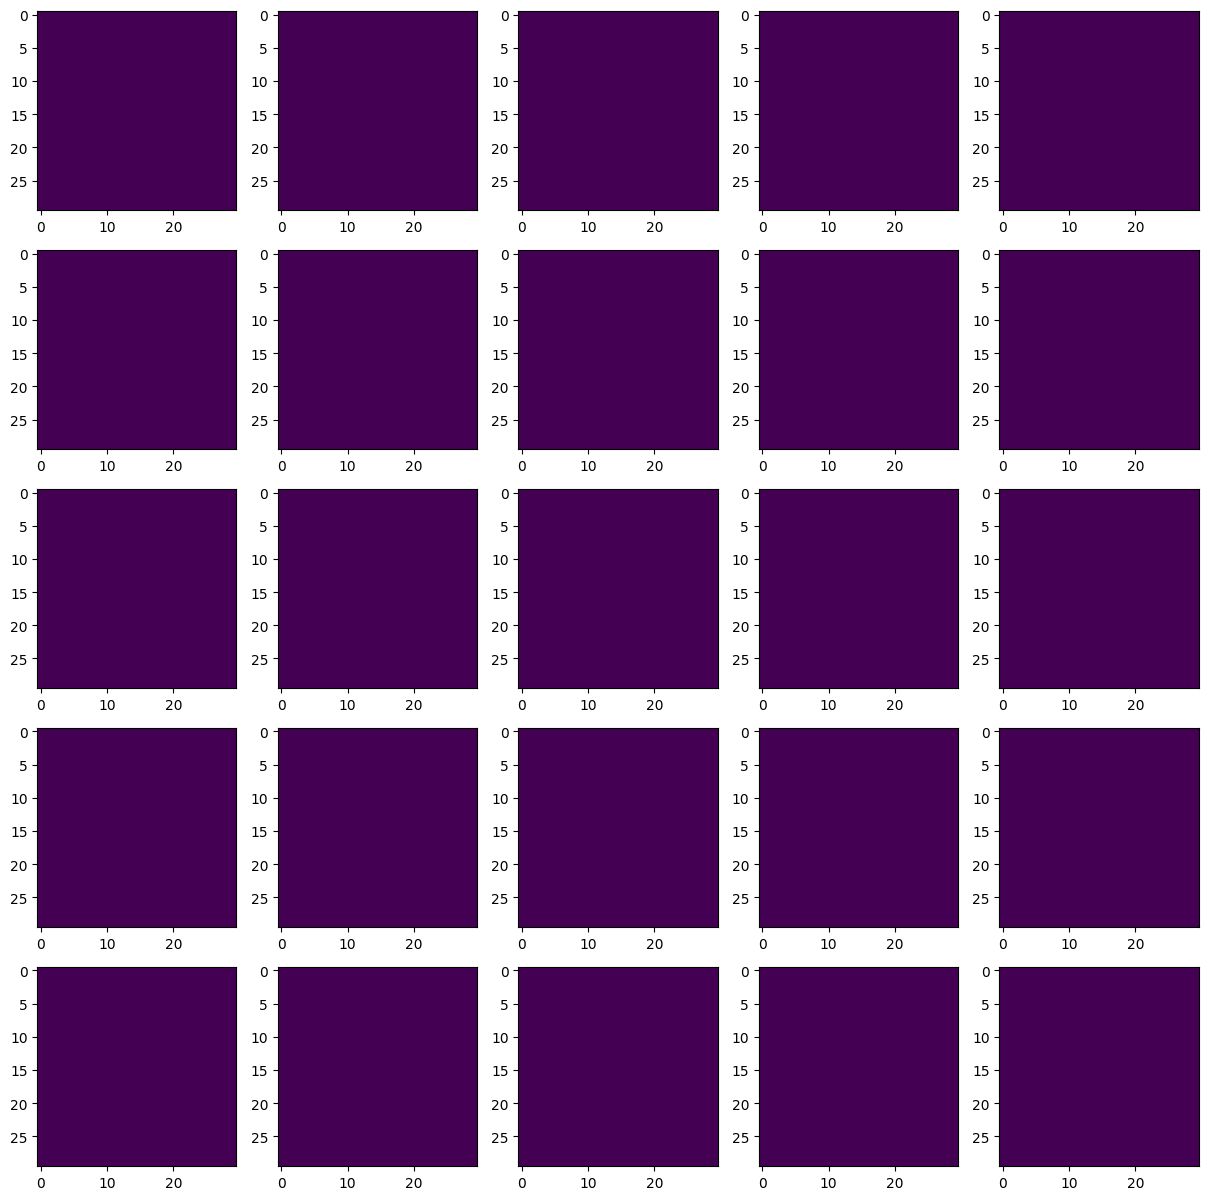

In [35]:
idx = 10

example = imgs[mask][idx]

fig, axs = plt.subplots(5,5, figsize=(15,15))

for band in range(5):
    for level in range(5):
        axs[band][level].imshow(example[level,band,:])

plt.show()

In [27]:
mask = (imgs.sum((3,4))==0).all((1,2))

In [28]:
mask.sum()

615

In [2]:
df = pd.read_csv("../data/SERSIC/df_train_delight.csv")
#df = pd.read_csv("../data/SERSIC/df_pasquet_sersic_01_percent.csv")
#df = pd.read_csv("../data/SERSIC/df_train_clean_2_percent.csv")

### EDA

In [ ]:
# Radio de las elipses de Sersic (3 veces el radio) en pixeles
# En este caso seleccionamos 210 pixeles de radio

print(df["rSerRadius"].max()*3/0.25)
print(df["rSerRadius"].median()*3/0.25)
print(df["rSerRadius"].mean()*3/0.25)
print(df["rSerRadius"].std()*3/0.25)

data = df["rSerRadius"] * 3 / 0.25

# Definir bines logarítmicos desde 1 a 1000 (puedes ajustar la cantidad de bines)
bins = np.logspace(np.log10(1), np.log10(1000), num=20)

plt.hist(data, bins=np.linspace(0,300,30), histtype="step", linewidth=1.5)


#plt.xscale("log")
plt.yscale("log")
plt.xlabel("Major Axis [pix]")
plt.ylabel("Frecuencia")
plt.show()

### Funciones

In [27]:
def plot_galaxy_and_sersic(df, idx, Ie=1.0, n=4):
    """
    Visualiza una galaxia con su perfil radial, su perfil de Sérsic y distribuciones de posiciones 
    aleatorias de supernovas simuladas.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame con parámetros de galaxias y supernovas. Debe contener 
        las columnas: 
        - 'host_ra', 'host_dec' (coordenadas en grados, usadas en `get_sdss_img`)
        - 'rSerRadius' (radio efectivo en arcsec)
        - 'rSerAb' (relación de ejes b/a)
        - 'rSerPhi' (ángulo de posición en grados)
        - 'dx', 'dy' (desplazamiento en píxeles de la supernova respecto al centro).
    idx : int
        Índice de la fila en el DataFrame correspondiente a la galaxia a visualizar.
    Ie : float, optional
        Intensidad central del perfil de Sérsic. Default es 1.0.
    n : int, optional
        Índice de Sérsic (concentración del perfil). Default es 4 (perfil de de Vaucouleurs).

    Returns
    -------
    sersic_img : np.ndarray
        Imagen 2D con el perfil de Sérsic generado para la galaxia.
    random_pos : np.ndarray
        Arreglo de forma (1000, 2) con posiciones aleatorias simuladas de supernovas 
        dentro del perfil de Sérsic, centradas en el núcleo de la galaxia.

    Notes
    -----
    - La primera figura muestra la galaxia real con el perfil elíptico y 
      la posición de la supernova observada.
    - La segunda figura muestra el perfil de Sérsic simulado.
    - La tercera figura muestra un mapa de calor con las posiciones simuladas 
      de la supernova en 1000 iteraciones.
    """
    row = df.iloc[idx]
    image_data = get_galaxy_img(df, idx, level=0, size=240) #Imagen de 240x240 con resolucion 0.25 arcsec/pix

    # Coordenadas del centro
    x_center, y_center = image_data.shape[0]//2 -1 , image_data.shape[1]//2 -1

    # Parámetros de Sérsic
    Re_arcsec = row["rSerRadius"]
    b_over_a = row["rSerAb"]
    theta_sersic = row["rSerPhi"]  # Usar el ángulo original
    pixel_scale = 0.25
    Re_pix = Re_arcsec / pixel_scale
    A_pix = Re_pix
    B_pix = A_pix * b_over_a

    # Generar perfil de Sérsic
    sersic_img = sersic_profile(
        image_shape=image_data.shape,
        x_center=x_center, y_center=y_center,
        Re_arcsec=Re_arcsec,
        b_over_a=b_over_a,
        theta_deg=theta_sersic,  
        pixel_scale=pixel_scale,
        Ie=Ie,
        n=n
    )

    # vemos las posiciones que tomo la supernova en 1000 iteraciones
    random_pos = []
    for _ in range(10000):
        pos = generate_random_pos(sersic_radius = Re_arcsec, 
                                    sersic_ab = b_over_a, 
                                    sersic_phi = theta_sersic, 
                                    img_size = image_data.shape[0])
        random_pos.append(pos) 

    random_pos =  np.array(random_pos) + x_center
    x_iter = random_pos[:, 0]
    y_iter = random_pos[:, 1]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=300)

    dx, dy = row[["dx","dy"]].values

    x_star = x_center + dx
    y_star = y_center + dy

    # Imagen real con elipse
    ax1 = axes[0]

    # Posicion SN real
    ax1.scatter(x_star, y_star,
                marker='*',         
                color='yellow',     
                s=500,              
                edgecolor='black')  
    
    ax1.imshow(image_data, cmap='gray', origin="lower",
               vmin=np.percentile(image_data, 1),
               vmax=np.percentile(image_data, 99))
    

    for r in [3]:
        ellipse = Ellipse((x_center, y_center),
                        width=B_pix * 2 * r,
                        height=A_pix * 2 * r,
                        angle=theta_sersic+90,
                        edgecolor='red',
                        facecolor='none',
                        lw=1.5,
                        linestyle='--' if r < 3 else '-')
        ax1.add_patch(ellipse)

    ax1.set_title("Galaxia con perfil elíptico")
    ax1.axis('off')

    # Mostrar perfil de Sérsic
    ax2 = axes[1]
    im = ax2.imshow(sersic_img, cmap='viridis', vmin=0, vmax=150, origin="lower")

    # Posciones SN arbitrarias
    for r in [3]:
        ellipse = Ellipse((x_center, y_center),
                        width=B_pix * 2 * r,
                        height=A_pix * 2 * r,
                        angle=theta_sersic+90,
                        edgecolor='red',
                        facecolor='none',
                        lw=1.5,
                        linestyle='--' if r < 3 else '-')
        ax2.add_patch(ellipse)

    ax2.set_title("Perfil de Sérsic (n=4)")
    ax2.axis('off')
    fig.colorbar(im, ax=ax2, label='Intensidad')

    ax3 = axes[2]
    hist, _, _ = np.histogram2d(x_iter, y_iter, bins=240, range=[[0, 240], [0, 240]])
    im3 = ax3.imshow(hist.T, cmap='viridis', interpolation='nearest', origin="lower", vmin=0, vmax=30)
    ax3.set_title('Posiciones supernova 10000 sampleos arbitrarios')
    ax3.axis('off')
    fig.colorbar(im3, ax=ax3, label='Frecuencia')


    plt.tight_layout()
    plt.show()

    return sersic_img, random_pos

### Plots

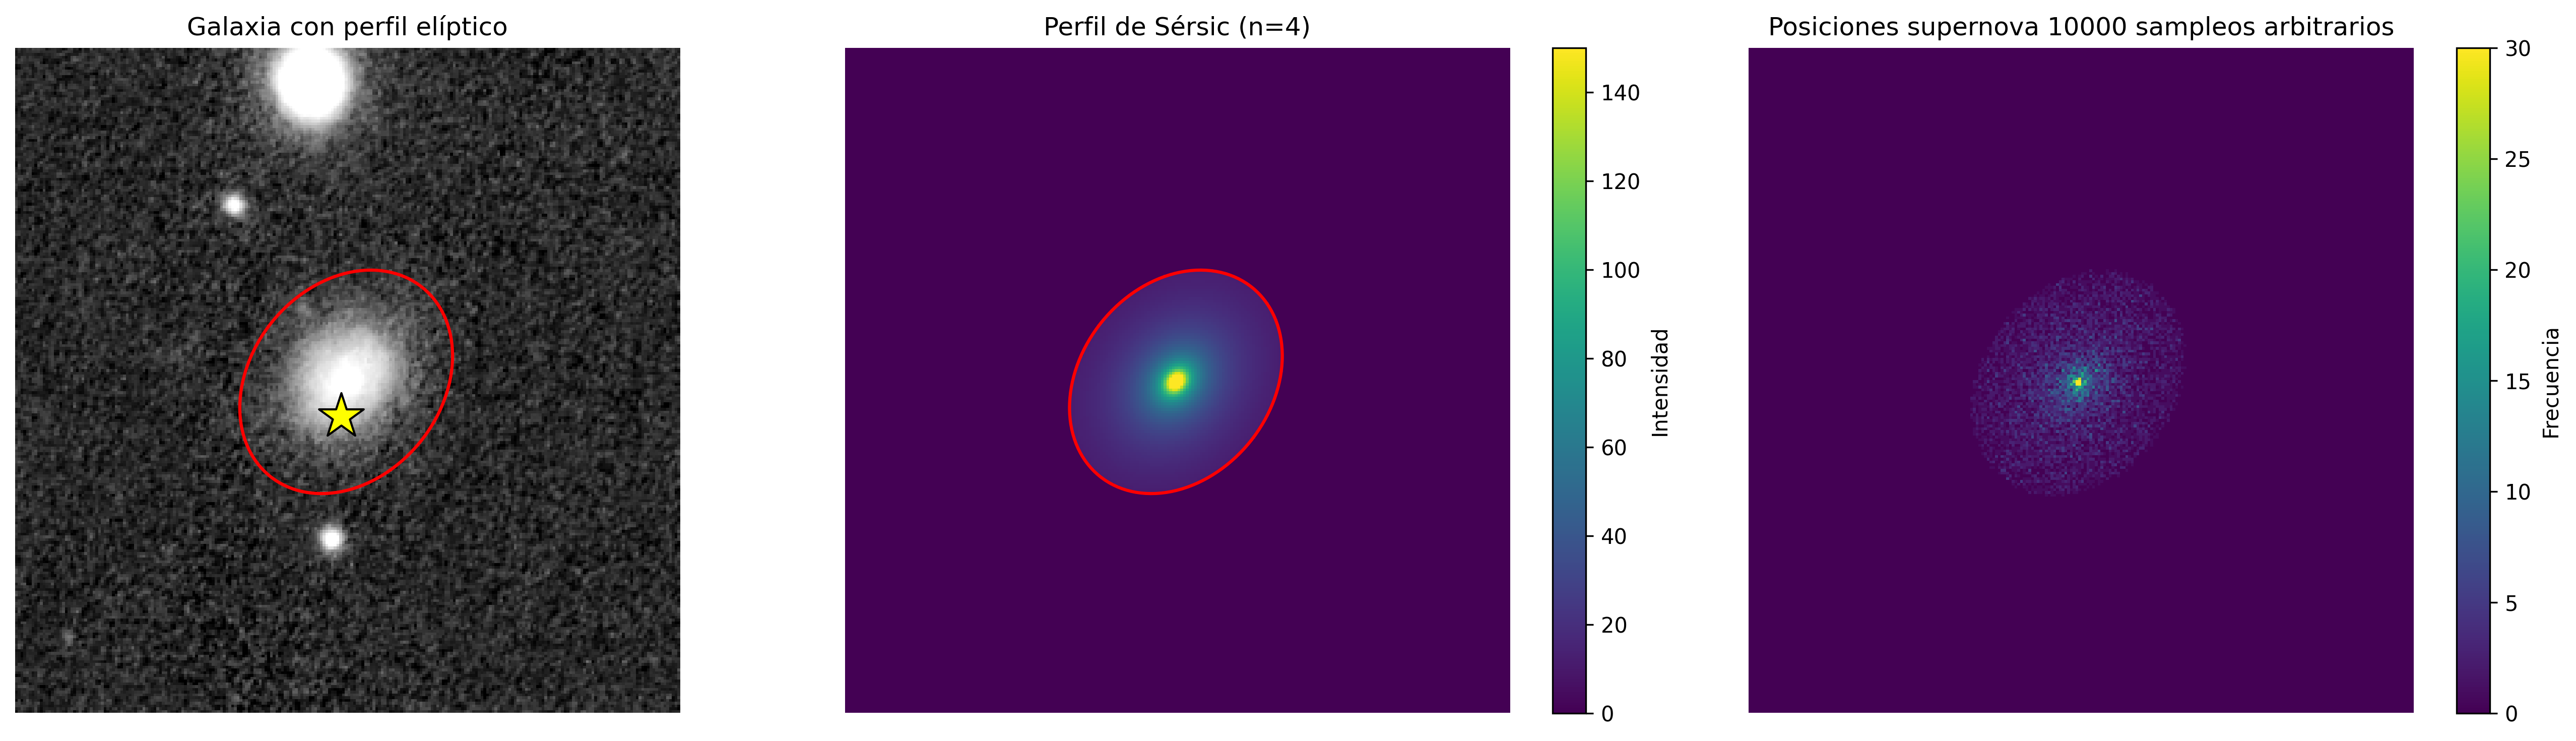

In [28]:
for idx in range(1):
    _ = plot_galaxy_and_sersic(df = df, idx = idx) 